In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image
import os

from keras.utils import to_categorical

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
gesture_names = dict()
reverse_gesture_names = dict()

count = 0
for i in os.listdir('../input/leapgestrecog/leapGestRecog/00'):
    gesture_names[i] = count
    reverse_gesture_names[count] = i
    count = count + 1
    
gesture_names

{'02_l': 0,
 '01_palm': 1,
 '05_thumb': 2,
 '07_ok': 3,
 '04_fist_moved': 4,
 '06_index': 5,
 '08_palm_moved': 6,
 '09_c': 7,
 '10_down': 8,
 '03_fist': 9}

In [3]:
X_Data = []
Y_Data = []

for i in range(0,3):
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i)):
        for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j):
            image = cv2.imread('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k, cv2.IMREAD_COLOR)
            image = cv2.flip(image, 1)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (41,41), 0)
            ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            thresh = cv2.resize(thresh, (224,224))
            thresh = np.array(thresh)
            X_Data.append(thresh)
            Y_Data.append(gesture_names[j])

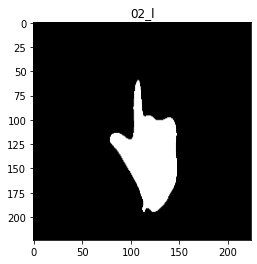

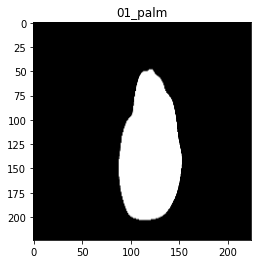

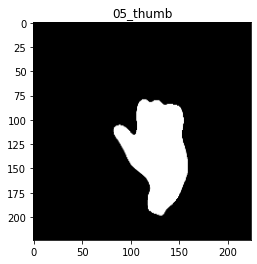

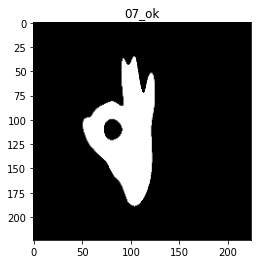

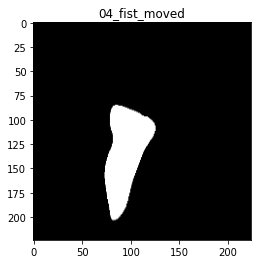

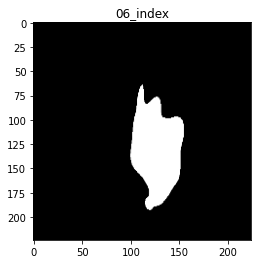

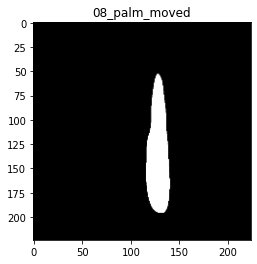

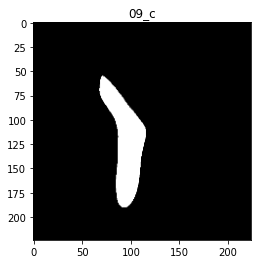

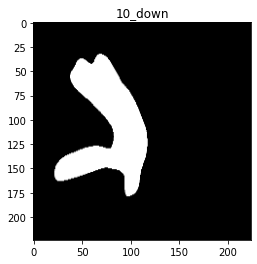

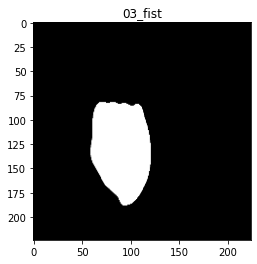

In [4]:
import matplotlib.pyplot as plt
for i in range(0,10):
    plt.title(reverse_gesture_names[Y_Data[i*200]])
    plt.imshow(X_Data[i*200], cmap='gray')
    plt.show()

In [5]:
X_Data = np.array(X_Data, dtype="float32")
Y_Data = np.array(Y_Data)

In [6]:
print(X_Data.shape)
print(Y_Data.shape)

(6000, 224, 224)
(6000,)


In [7]:
X_Data = np.stack((X_Data,)*3, axis=-1)
X_Data /= 255
Y_Data = to_categorical(Y_Data)

In [8]:
print(X_Data.shape, Y_Data.shape)

(6000, 224, 224, 3) (6000, 10)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size = 0.2, random_state=12, stratify=Y_Data)

In [10]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model

In [17]:
file_path = 'saved_model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks =[early_stopping, model_checkpoint])

Train on 4800 samples, validate on 1200 samples
Epoch 1/200
4800/4800 [==============================] - 5s 985us/step - loss: 0.3048 - accuracy: 0.8967 - val_loss: 0.0084 - val_accuracy: 0.9975
Epoch 2/200
 160/4800 [>.............................] - ETA: 3s - loss: 0.0045 - accuracy: 1.0000  

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4800/4800 [==============================] - 4s 881us/step - loss: 0.0228 - accuracy: 0.9944 - val_loss: 0.0021 - val_accuracy: 0.9992
Epoch 3/200
4800/4800 [==============================] - 4s 896us/step - loss: 7.7202e-04 - accuracy: 0.9996 - val_loss: 4.3078e-04 - val_accuracy: 1.0000
Epoch 4/200
4800/4800 [==============================] - 4s 920us/step - loss: 0.0196 - accuracy: 0.9960 - val_loss: 0.0335 - val_accuracy: 0.9933
Epoch 5/200
4800/4800 [==============================] - 5s 950us/step - loss: 0.0171 - accuracy: 0.9954 - val_loss: 0.0078 - val_accuracy: 0.9975
Epoch 6/200
4800/4800 [==============================] - 5s 943us/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 3.9554e-05 - val_accuracy: 1.0000
Epoch 7/200
4800/4800 [==============================] - 4s 899us/step - loss: 5.8505e-05 - accuracy: 1.0000 - val_loss: 1.8264e-05 - val_accuracy: 1.0000
Epoch 8/200
4800/4800 [==============================] - 4s 914us/step - loss: 5.1854e-05 - accuracy: 1.0000 -

4800/4800 [==============================] - 4s 879us/step - loss: 1.3899e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 56/200
4800/4800 [==============================] - 4s 889us/step - loss: 8.6616e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 57/200
4800/4800 [==============================] - 4s 895us/step - loss: 3.7428e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 58/200
4800/4800 [==============================] - 4s 897us/step - loss: 2.3281e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 59/200
4800/4800 [==============================] - 4s 907us/step - loss: 1.2033e-06 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 60/200
4800/4800 [==============================] - 5s 982us/step - loss: 4.5188e-07 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 61/200
4800/4800 [==============================] - 4s 908us/step - loss: 1.1010e-06 - accuracy

Epoch 109/200
4800/4800 [==============================] - 4s 916us/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.0440 - val_accuracy: 0.9950
Epoch 110/200
4800/4800 [==============================] - 4s 900us/step - loss: 3.0846e-04 - accuracy: 0.9998 - val_loss: 0.0316 - val_accuracy: 0.9975
Epoch 111/200
4800/4800 [==============================] - 4s 917us/step - loss: 1.5798e-06 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 0.9975
Epoch 112/200
4800/4800 [==============================] - 4s 930us/step - loss: 1.2317e-06 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9975
Epoch 113/200
4800/4800 [==============================] - 4s 890us/step - loss: 4.7578e-04 - accuracy: 0.9998 - val_loss: 0.0133 - val_accuracy: 0.9983
Epoch 114/200
4800/4800 [==============================] - 4s 919us/step - loss: 9.6803e-06 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9983
Epoch 115/200
4800/4800 [==============================] - 5s 1ms/step - loss: 3.6364e

4800/4800 [==============================] - 5s 958us/step - loss: 1.8298e-04 - accuracy: 0.9998 - val_loss: 2.8379e-04 - val_accuracy: 1.0000
Epoch 163/200
4800/4800 [==============================] - 4s 908us/step - loss: 1.1673e-09 - accuracy: 1.0000 - val_loss: 1.6364e-04 - val_accuracy: 1.0000
Epoch 164/200
4800/4800 [==============================] - 4s 903us/step - loss: 2.7319e-10 - accuracy: 1.0000 - val_loss: 1.7184e-04 - val_accuracy: 1.0000
Epoch 165/200
4800/4800 [==============================] - 4s 892us/step - loss: 2.4835e-11 - accuracy: 1.0000 - val_loss: 1.6397e-04 - val_accuracy: 1.0000
Epoch 166/200
4800/4800 [==============================] - 4s 883us/step - loss: 5.4638e-10 - accuracy: 1.0000 - val_loss: 1.6423e-04 - val_accuracy: 1.0000
Epoch 167/200
4800/4800 [==============================] - 4s 899us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.6255e-04 - val_accuracy: 1.0000
Epoch 168/200
4800/4800 [==============================] - 4s 877us/step

In [25]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

1200/1200 [==============================] - 1s 491us/step
Accuracy:0.9991666674613953


In [ ]:
from IPython.display import FileLink, FileLinks
FileLinks('.') 